# Formula 1: The greatest driver of all time? A look at the data


This code is used to load, transform and extract insights from data relating to the formula 1 world championship 1950-2021

## Gather and Load Data

1) First Up, import required packages for Python. 

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

2) Load in Datasets. 
All datasets can be found on Kaggle here: https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020 where they are ultimatley sourced from the Ergast Developer API found here http://ergast.com/mrd/

In [10]:
drivers = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\drivers.csv") # driver dataset
results = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\results.csv") # race result dataset 
standings = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\driver_standings.csv") #Driver Standings
races = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\races.csv") #Races
lap_times = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\lap_times.csv") #All lap times
constructor_standings = pd.read_csv(r"D:\Christopher\Documents\Udacity\Datasets\F1_Dataset\constructor_standings.csv") #Constructor Standings



3) Take a look at the data to get initial view on what is contained


In [11]:
# print(drivers.head())
# print(len(drivers.index))
# print(drivers.dtypes)
#print(races.dtypes)

In [12]:
#print(results.describe())
#print(lap_times.describe())
#print(standings.describe())
print(drivers['driverId'].shape[0])


853


In [325]:
#Check for nulls, check data quality  
drivers.isnull().sum()


driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64

## Analyse Data

Question 1. It is often asked - who is the greatest driver of all time? That is as easy as who has won the most championships right? Or the most races? Lets look at a number of metrics and see who comes out on top.

In [20]:
# Create Master Driver - Results table 
driver_results= drivers[['driverId','driverRef']].merge(results[['driverId','position','grid','constructorId',
                                                                 'positionOrder','points','raceId']],
                                                        on ='driverId', how ='left')
driver_finish = driver_results.copy()
driver_finish.head()
driver_finish.loc[driver_finish['driverId'] == 1]

# Calculate Absolute Wins By Driver 
driver_wins= driver_finish.query('positionOrder==1')
top_driver = driver_wins.groupby(['driverId','driverRef'])['positionOrder'].sum().reset_index().sort_values(
    by='positionOrder', ascending = False)
print(top_driver.head())

# Driver with the most total career points. 
# Check to make sure that the number of points for a win do not change 
driver_wins['points'].unique() 
#Looks like the number of points changed, this seems like a bad comparison - create a new standardised points score column
driver_finish['standardised'] = np.where(driver_finish['positionOrder'] <= 10, (driver_finish['positionOrder']*-1)+11, 0)

# Find driver with most standardised career points
most_points = driver_finish.groupby(['driverId','driverRef'])['points'].sum().reset_index().sort_values(
    by='points', ascending = False)
print(most_points.head())

# Driver who has qualified first the most times 
driver_poles= driver_finish.query('grid==1')
top_qualifier = driver_poles.groupby(['driverId','driverRef'])['grid'].sum().reset_index().sort_values(
    by='grid', ascending = False)
print(top_qualifier.head())

# Most championship wins 
# Need to find the final race and take final points tally & position 
max_race = races.groupby(['year'], as_index=False)['round'].max()
max_race.columns = ['year','max_race']
max_race2 = pd.merge(races,max_race.drop_duplicates(), how='left', 
                     left_on=['year','round'],
                     right_on = ['year','max_race'], indicator=True)
max_race3 = max_race2[max_race2['_merge'] == 'both']
max_race4 = max_race3[['raceId','year','round']]
max_race4
#Pull positions on final race day, join max_race3 to standings
standings2 = pd.merge(max_race4,standings,how='left',left_on =['raceId'], right_on = ['raceId'], indicator=True).dropna()
#Join Driver Information 
Champions = pd.merge(standings2[standings2['position']==1],drivers, on=['driverId'])
Top_Champions = Champions.groupby(['driverId','driverRef'], as_index=False)['position'].count().sort_values(
    by='position', ascending = False)
print(Top_Champions.head())



    driverId           driverRef  positionOrder
0          1            hamilton             98
15        30  michael_schumacher             91
11        20              vettel             53
29       117               prost             51
27       102               senna             41
    driverId  driverRef  points
0          1   hamilton  3872.0
19        20     vettel  3018.0
3          4     alonso  1904.0
7          8  raikkonen  1863.0
2          3    rosberg  1594.5
    driverId           driverRef  grid
0          1            hamilton   100
16        30  michael_schumacher    68
25       102               senna    65
12        20              vettel    57
69       373               clark    34
    driverId           driverRef  position
0        1.0            hamilton         7
6       30.0  michael_schumacher         7
30     579.0              fangio         5
5       20.0              vettel         4
12     117.0               prost         4


Question 1B: We may want to consider some more complex measures, calculated below. 

In [21]:
#Wins Per Race
# Pull out number of race starts. # If they qualified then assume start. 
#Count Race Starts 
driver_starts= driver_results[(driver_results['grid']!=0) & (driver_results['grid'].notnull())]   #remove DNQ and Nulls
driver_starts = driver_starts.groupby(['driverId','driverRef'])['raceId'].nunique().reset_index().sort_values(by='raceId', ascending = False) #Unique Races
driver_starts.set_index('driverId')
print(driver_starts)

def starts (row):
    '''
    INPUT:
    Driver ID
    
    OUTPUT:
    Number of starts from the start table(driver_starts).
    
    '''
    starts = float(driver_starts.loc[driver_starts['driverId'] == row['driverId']]['raceId'])
    return starts


def per_start_win (row):
    '''
    INPUT:
    The number of wins a driver has achieved from wins table.
    The Driver ID from the wins table. 
    
    OUTPUT:
    Number of starts from the start table(driver_starts).
    Number of wins per race start (calculated).
    
    '''
    starts = float(driver_starts.loc[driver_starts['driverId'] == row['driverId']]['raceId'])
    psw = row['positionOrder'] / starts 
    return pd.Series([starts, float(psw)])

#Remove Drivers with Zero Wins
top_driver2 = top_driver.dropna(subset=['positionOrder'])
#Calculate wins per start and place in top driver table 
top_driver2[["starts","WinsPerStart"]]= top_driver2.apply(per_start_win,axis=1)
top_driver2.columns = ['DriverId','Driver','Wins','Starts','WinsPerStart']
top_driver3 = top_driver2.sort_values(by = ['WinsPerStart'],ascending = False)

# Poles Per Race Start
top_qualifier["starts"]= top_qualifier.apply(starts,axis=1)
top_qualifier["PolesPerStart"] = top_qualifier['grid'] / top_qualifier['starts']
top_qualifier2 = top_qualifier.sort_values(by = 'PolesPerStart', ascending = False)
top_qualifier2.columns = ['driverId','Driver','Poles','Starts','PolesPerStart']
print(top_qualifier2.head())

#Other metrics to looks at: 
#Highest Conversion rate
#Average Position
#Most fast laps 

#Just for fun stats: 
#Laps led

     driverId           driverRef  raceId
7           8           raikkonen     333
21         22         barrichello     325
3           4              alonso     318
17         18              button     309
29         30  michael_schumacher     308
..        ...                 ...     ...
537       604              picard       1
536       603              guelfi       1
535       602             la_caze       1
533       600            goethals       1
287       318                roos       1

[784 rows x 3 columns]
    driverId    Driver  Poles  Starts  PolesPerStart
84       579    fangio     29    51.0       0.568627
69       373     clark     34    72.0       0.472222
91       647    ascari     14    32.0       0.437500
25       102     senna     65   161.0       0.403727
0          1  hamilton    100   270.0       0.370370


Visualise the results of this question

<AxesSubplot:title={'center':'Number of Driver Championships'}, ylabel='Driver'>

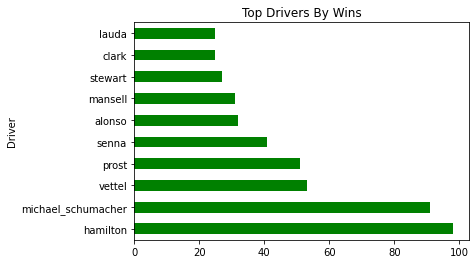

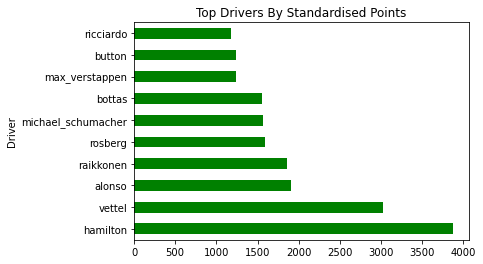

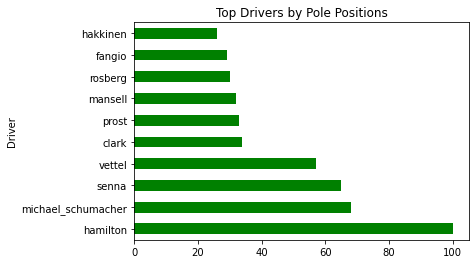

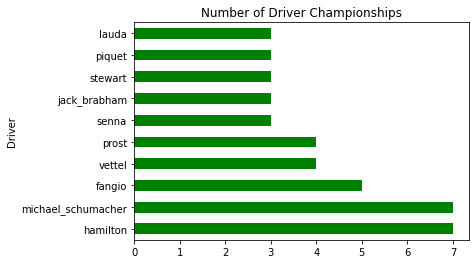

In [22]:
# First- absolute number of wins
top_driver.head(10).plot(kind='barh',x='driverRef',y='positionOrder' , xlabel ="Driver" , ylabel = "Wins" , title = "Top Drivers By Wins", color = 'green', legend = None)

# Top Driver by total standardised points
most_points.head(10).plot(kind='barh',x='driverRef',y='points' , xlabel ="Driver"  , title = "Top Drivers By Standardised Points", color = 'green', legend = None)

#Top Qualifier 
top_qualifier.head(10).plot(kind='barh',x='driverRef',y='grid' , xlabel ="Driver"  , title = "Top Drivers by Pole Positions", color = 'green', legend = None)

#Top Champions
Top_Champions.head(10).plot(kind='barh',x='driverRef',y='position' , xlabel ="Driver"  , title = "Number of Driver Championships", color = 'green', legend = None)

<AxesSubplot:title={'center':'Top Poles Per Entry %'}, xlabel='Driver', ylabel='Poles Per Start'>

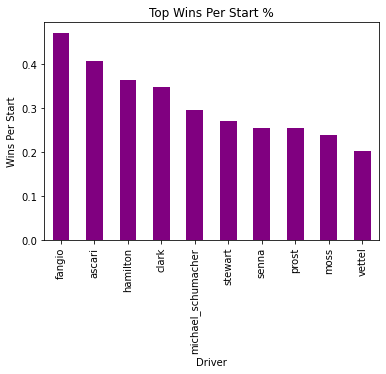

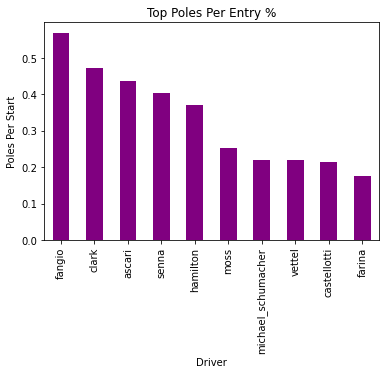

In [24]:
#Question 1B Visualisations
#Wins Ratio
# First- absolute number of wins
top_driver3[top_driver3["Starts"]>10].head(10).plot(kind='bar',x='Driver',y='WinsPerStart' , xlabel ="Driver" , ylabel = "Wins Per Start" , title = "Top Wins Per Start %", color = 'purple' , legend = None)

# Absolute number of poles
top_qualifier2[top_qualifier2["Starts"]>10].head(10).plot(kind='bar',x='Driver',y='PolesPerStart' , xlabel ="Driver" , ylabel = "Poles Per Start" , title = "Top Poles Per Entry %", color = 'purple' , legend = None)

Conclusion - on an absolute basis the modern era drivers dominate, however if we look at relative metrics the results become less clear. 

Question 2 - How much has really changed in the past 70 years? [NOT USED IN BLOG] 

year
1996    122689.933333
1997    132219.642225
1998    145076.642398
1999    119180.429918
2000    123424.785024
Name: milliseconds, dtype: float64


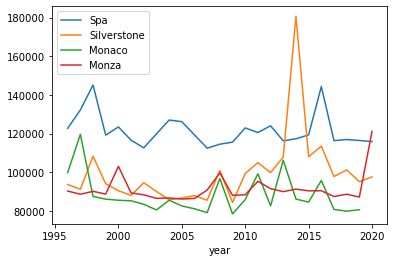

      raceId  laps milliseconds  positionOrder  year  circuitId    Seconds  \
818      839    80     10277400              1  1950         14  10277.400   
817      838    64     10672800              1  1950         55  10672.800   
816      837    35     10046000              1  1950         13  10046.000   
815      836    42      7373700              1  1950         66   7373.700   
814      835   138     10015970              1  1950         19  10015.970   
...      ...   ...          ...            ...   ...        ...        ...   
1028    1038    53      6426056              1  2020         14   6426.056   
1039    1053    63      7354598              1  2021         21   7354.598   
1040    1054    66      5671421              1  2021         75   5671.421   
1038    1052    56      5523897              1  2021          3   5523.897   
1041    1055    66      5587680              1  2021          4   5587.680   

         Avg_lap  
818   128.467500  
817   166.762500  
816   

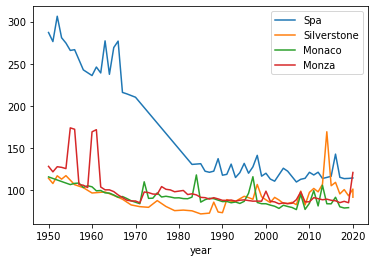

In [26]:
#Question 2: Have the cars got quicker over time?
#Import lap times 
#Find average pace across different seasons and decades at the 'classic' circuits. 
#Join year in to lap time to find average lap time each year.

average_lap = pd.merge(lap_times, races, on = 'raceId'  )
average_lap2 = average_lap.groupby(['year','circuitId'])['milliseconds'].mean().reset_index()
#By Circuit
spa = average_lap2[average_lap2['circuitId'] == 13].set_index('year').pop('milliseconds') #13
silverstone = average_lap2[average_lap2['circuitId'] == 9].set_index('year').pop('milliseconds') #13 #9 
monaco = average_lap2[average_lap2['circuitId'] == 6].set_index('year').pop('milliseconds') #6
monza = average_lap2[average_lap2['circuitId'] == 14].set_index('year').pop('milliseconds') #14

print(spa.head())
    
spa.plot(label = 'Spa')
silverstone.plot(label = 'Silverstone')
monaco.plot(label = 'Monaco')
monza.plot(label = 'Monza')
plt.legend()
plt.show()

#Only have data since 1996 so cannot compare to earlier years. As a proxy we can use the calculated average lap time from 'resutls'
# Calculate Absolute Wins By Driver 
winning_time = pd.merge(results[['raceId','laps','milliseconds','positionOrder']].query('positionOrder==1'), races[['year','raceId','circuitId']], on ='raceId', how ='left')
winning_time['Seconds'] =  (winning_time['milliseconds'].astype(int))/1000
winning_time['Avg_lap'] = winning_time['Seconds']/winning_time['laps']
winning_time = winning_time.sort_values(by = 'year')
print(winning_time)

spa2 =winning_time[winning_time ['circuitId'] == 13].set_index('year').pop('Avg_lap') #13
silverstone2 = winning_time[winning_time ['circuitId'] == 9].set_index('year').pop('Avg_lap') #9 
monaco2 = winning_time[winning_time ['circuitId'] == 6].set_index('year').pop('Avg_lap') #6
monza2 = winning_time[winning_time ['circuitId'] == 14].set_index('year').pop('Avg_lap') #14

spa2.plot(label = 'Spa')
silverstone2.plot(label = 'Silverstone')
monaco2.plot(label = 'Monaco')
monza2.plot(label = 'Monza')
plt.legend()
plt.show()


Looking at the average lap times over 70 year history of F1, we see steadily quicker laps right up until the early 1990s. From then, average laps have remained relatively flat, possibly indicative of the sport reaching a ceiling in terms of raw power and performance. Indeed, reading further in to this, we see that in more recent years, F1 engines have actually got smaller in the drive for efficiency and sustainability and the regulations have been updated to reflect this. 

Of course, it should be acknowledged that this is not a foolproof comparison, the cars have changed very signiciantly over the years as regulations and technology have updated. The tracks themselves also may have undergone signicant changes, as is the case with Spa in the 1970s. 

For this reason, I conclude that this is not a particularly useful comparison to use when looking at drivers in different eras. 


## Question 3: Modelling 

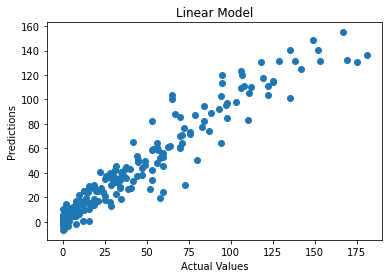

'R Squaredriables was 0.931724991568499'

In [83]:
#Question 3: Modelling Task - Can we Predict the final points tally by the 10th race of the season using basic regression techniques.

# We want each row to be one driver and one season. Some enhancements and transformation needed. 
#Team points previous season (standardised),results (standardised points) in first 10 races in seperate columns (standardisesd). 
#Number of races in the season
#Constructor position in the previous season
#Target Variable = Total standardised points in the season. 
#Use data from 2000 only initally. 

#Building our dataset:
#1. Distinct Year, Driver, Team - From Standings & races dataset from earlier. 
Drivers_In = Champions[['year','round','driverId']] 
d2 = pd.merge(driver_results[['driverId','constructorId','raceId']],
              races[['raceId','year']],on = 'raceId') #Determine what constructor a driver drove for in a certain year
d3 = d2[['driverId','constructorId','year']].drop_duplicates()
Drivers_In2 = d3

#2. Use results dataset, build standardised points data, use this to print out the final results
results_2 = pd.merge(driver_finish,races[['raceId','year','round']], on = 'raceId', how = 'left')
results_transpose = results_2[['year','driverId','round','standardised']]
results_3 = pd.pivot_table(results_transpose, values = 'standardised', columns = 'round' , 
                           index = ['driverId','year'],fill_value = 0 )
results_3['Total_Points'] = results_3.sum(axis = 1) #Total points for season
results_4 = results_3.reset_index()

Master_data = pd.merge(Drivers_In2,results_4, on = ['driverId','year']) #Join to 1

#3. Previous season results
Championship = constructor_standings   #Championship position on last day of the season
final_race = pd.merge(Championship, max_race4, on = 'raceId' , how = 'inner') 
final_race['last_year'] = final_race['year']+1
Master_data2 = pd.merge(Master_data, final_race[['constructorId','last_year','wins','position','round']],
                        left_on =['constructorId','year'], right_on = ['constructorId','last_year'],
                        how = 'left' )    #Join to master
Master_data3 = Master_data2.query('year != 2021 & year > 1990') #Remove latest year and also years below 1990

#Check input and output to cleanse for NAN etc 
Master_data4 = Master_data3.fillna(0)
#print(Master_data4.isna().sum())
Master_data5 = Master_data4.astype(int)
# print(Master_data5.dtypes)

#Define features & variable we are trying to predict:
X = Master_data5[[1,2,3,4,5,6,7,8,9,10,'wins','position','round']]
y = Master_data5['Total_Points'] 

# #Split into train and test (30% Test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30) 

# # Train Linear regression model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train) #Fit
        
# #Predict and score the model
y_test_preds = lm_model.predict(X_test) 

# Results
plt.scatter(y_test, y_test_preds)  #scatter graph for predicted values against test values
plt.xlabel('Actual Values')       #axis label
plt.ylabel('Predictions')         #axis label
plt.title('Linear Model')          #chart lable
plt.show()                        #shows visual 
"R Squaredriables was {}".format(r2_score(y_test, y_test_preds))

In [84]:

def Champion (year):
    """ Function to test total points model against specific season and return the
    
    ARGS:
    year - championship year
    
    OUTPUT: 
    Driver ID of actual champion. 
    Driver ID of champion predicted by the model. 
    
    """
    season = Master_data5[Master_data5['year']==year]
    Result = season.copy()
    predictors = season[[1,2,3,4,5,6,7,8,9,10,'wins','position','round']]
    Result['modelled_points'] =lm_model.predict(predictors)
    actual_champion =  Result['driverId'].loc[Result['Total_Points'].idxmax()]
    modelled_champion =  Result['driverId'].loc[Result['modelled_points'].idxmax()]
    if actual_champion == modelled_champion:
        success = True
        return 1
    else:
        success = False
        return 0
    print(year, actual_champion , modelled_champion, success) 

#Run model over past 20 years to measure success 
#Initiate variables  
tests = 0 
correct_answers = 0 
success = False

for i in range(2000,2020):   
    tests += 1  
    if  Champion(i) == 1:
        correct_answers += 1
    else:
        0
        
print('Success Rate:', correct_answers/tests)




Success Rate: 0.65


[END]